<div class="alert alert-block alert-success" style="font-size:25px">
🦴 1. Imports, constants, dependencies 🦴
</div>

In [1]:
try:
    import pylibjpeg
    print('import pylibjpeg success')
except:
    # The following *.whl files were collected from these pip packages:
    #!pip install -U "python-gdcm" pydicom pylibjpeg    # Required for JPEG decompression. See: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341412
    #!pip install -U torchvision                        # For EfficientNetV2

    # Offline dependencies:
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

import pylibjpeg success


In [2]:
import gc
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.model_selection import GroupKFold
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_M_Weights.DEFAULT
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
EFFNET_MAX_TRAIN_BATCHES = 4000
EFFNET_MAX_EVAL_BATCHES = 200
ONE_CYCLE_MAX_LR = 0.0001
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 1000
EFFNET_CHECKPOINTS_PATH = '../input/rsna-2022-base-effnetv2'
FRAC_LOSS_WEIGHT = 2.
N_FOLDS = 5
METADATA_PATH = '../input/vertebrae-detection-checkpoints'

PREDICT_MAX_BATCHES = 1e9

# Common
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

os.environ["WANDB_MODE"] = "online"
if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = '67c99389e1ae37b747c40634c51802a4bf019d49'

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = f'/root/autodl-tmp/RSNA_data'
    TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
    TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
    METADATA_PATH = f'{RSNA_2022_PATH}/Metadata'
    EFFNET_CHECKPOINTS_PATH = f'{RSNA_2022_PATH}/effnetv2'
    os.environ['WANDB_API_KEY'] = '67c99389e1ae37b747c40634c51802a4bf019d49'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2


Running locally


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 2. Loading train/eval/test dataframes 🦴
</div>

### Train data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/train.csv`
2. Joining data with slice information from metadata dataset `../input/rsna-2022-spine-fracture-detection-metadata/meta_train_with_vertebrae.csv`
3. Adding `Splits` column to facilitate train/eval splits.

In [3]:
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
print(len(df_train))
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.20574'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.20756'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.29952'].index)
df_train = df_train.drop(df_train[df_train['StudyInstanceUID'] == '1.2.826.0.1.3680043.8362'].index)
print(len(df_train))
df_train.sample(2)

2019
2015


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
624,1.2.826.0.1.3680043.28705,1,0,0,0,0,0,0,1
229,1.2.826.0.1.3680043.31642,0,0,0,0,0,0,0,0


In [4]:
# rsna-2022-spine-fracture-detection-metadata contains inference of C1-C7 vertebrae for all training sample (95% accuracy)
df_train_slices = pd.read_csv(f'{METADATA_PATH}/train_segmented.csv')
c1c7 = [f'C{i}' for i in range(1, 8)]
df_train_slices[c1c7] = (df_train_slices[c1c7] > 0.5).astype(int)
print(df_train_slices.sample(5)[['StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].to_markdown())

|        | StudyInstanceUID          |   C1 |   C2 |   C3 |   C4 |   C5 |   C6 |   C7 |
|-------:|:--------------------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| 121486 | 1.2.826.0.1.3680043.15404 |    0 |    1 |    1 |    0 |    0 |    0 |    0 |
| 517628 | 1.2.826.0.1.3680043.31450 |    0 |    0 |    1 |    1 |    0 |    0 |    0 |
| 424806 | 1.2.826.0.1.3680043.27578 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |
|  47624 | 1.2.826.0.1.3680043.12351 |    0 |    0 |    0 |    1 |    1 |    1 |    0 |
| 105469 | 1.2.826.0.1.3680043.14615 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |


In [5]:
df_train = df_train_slices.set_index('StudyInstanceUID').join(df_train.set_index('StudyInstanceUID'),
                                                              rsuffix='_fracture').reset_index().copy()
df_train = df_train.query('StudyInstanceUID != "1.2.826.0.1.3680043.20574"').reset_index(drop=True)
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
230572,1.2.826.0.1.3680043.19705,200,512,512,0.625,-57.356,-51.661,-50.387000,1,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
396672,1.2.826.0.1.3680043.2645,439,512,512,1.000,-76.000,35.000,66.900024,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
split = GroupKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, groups=df_train.StudyInstanceUID)):
    df_train.loc[test_idx, 'split'] = k
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split
465008,1.2.826.0.1.3680043.29287,365,512,512,1.0,-57.642105,80.231579,167.599976,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
433677,1.2.826.0.1.3680043.28019,18,512,512,0.5,-90.581890,-33.941270,1785.800000,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


### Test data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/test.csv`
2. Joining data with slice information collected from test image folders `../input/rsna-2022-cervical-spine-fracture-detection/test_images/*/*`

In [7]:
df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
    # test_images and test.csv are inconsistent in the dev dataset, fixing labels for the dev run.
    df_test = pd.DataFrame({
        "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
        "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
        "prediction_type": ["C1", "C1", "patient_overall"]}
    )

df_test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [8]:
test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
print(test_slices[0])
print(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm')
test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
print(test_slices[0])
df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
df_test_slices.sample(2)

/root/autodl-tmp/RSNA_data/test_images/1.2.826.0.1.3680043.22327/154.dcm
/root/autodl-tmp/RSNA_data/test_images/(.*)/(.*).dcm
('1.2.826.0.1.3680043.22327', '154')


,StudyInstanceUID,Slice
823,1.2.826.0.1.3680043.25399,66
603,1.2.826.0.1.3680043.25399,360


In [9]:
df_test = df_test.set_index('StudyInstanceUID').join(df_test_slices.set_index('StudyInstanceUID')).reset_index()
df_test.sample(2)

,StudyInstanceUID,row_id,prediction_type,Slice
242,1.2.826.0.1.3680043.22327,1.2.826.0.1.3680043.22327_C1,C1,35
1268,1.2.826.0.1.3680043.5876,1.2.826.0.1.3680043.5876_C1,patient_overall,54


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 3. Dataset class 🦴
</div>

`EffnetDataSet` class returns images of individual slices. It uses a dataframe parameter `df` as a source of slices metadata to locate and load images from `path` folder. It accepts transforms parameter which we set to `WEIGHTS.transforms()`. This is a set of transforms used to pre-train the model on ImageNet dataset.

Text(0.5, 1.0, 'jpeg')

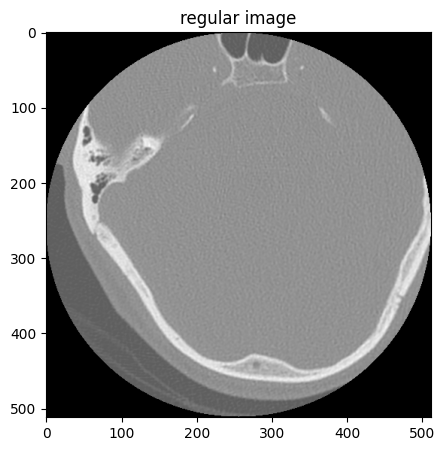

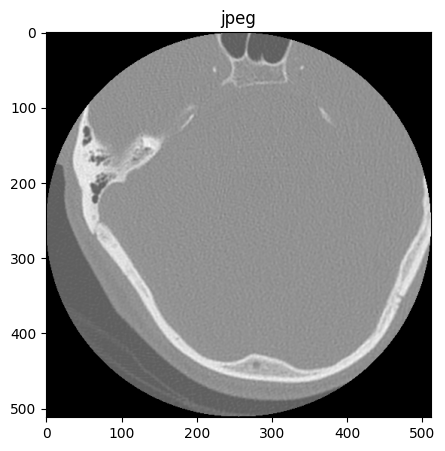

In [10]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [11]:
class EffnetDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')

        try:
            img = load_dicom(path)[0]
            # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            img = np.transpose(img, (2, 0, 1))
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture',
                                                            'C5_fracture', 'C6_fracture', 'C7_fracture']].astype(
                'float32').values)
            vert_targets = torch.as_tensor(
                self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets  # we only enable targets that are visible on the current slice
            return img, frac_targets, vert_targets
        return img

    def __len__(self):
        return len(self.df)


In [12]:
ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y_frac, y_vert = ds_train[42]
print(X.shape, y_frac.shape, y_vert.shape)

torch.Size([3, 480, 480]) torch.Size([7]) torch.Size([7])


In [13]:
def plot_sample_patient(df, ds):
    patient = np.random.choice(df.query('patient_overall > 0').StudyInstanceUID)
    df = df.query('StudyInstanceUID == @patient')
    display(df)

    frac = np.stack([ds[i][1] for i in df.index])
    vert = np.stack([ds[i][2] for i in df.index])
    ax = plt.subplot(1, 2, 1)
    ax.plot(frac)
    ax.set_title(f'Vertebrae with fractures by slice (masked by visible vertebrae). uid:{patient}')
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f'Visible vertebrae by slice. uid:{patient}')
    ax.plot(vert)

# plot_sample_patient(df_train, ds_train)

In [14]:
# Only X values returned by the test dataset
ds_test = EffnetDataSet(df_test, TEST_IMAGES_PATH, WEIGHTS.transforms())
X = ds_test[42]
X.shape

torch.Size([3, 480, 480])

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 4. Model 🦴
</div>


In Pytorch we use create_feature_extractor to access feature layers of pre-existing models. Final flat layer of `efficientnet_v2_s` model is called `flatten`. We'll build our classification layer on top of it. 

In [15]:
from tensorboardX import SummaryWriter
from torch.autograd import Variable

writer = SummaryWriter(log_dir='./log', comment='effnet')


In [16]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_m(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        with writer:
            writer.add_graph(effnet, (Variable(torch.rand(32, 3, 384, 384)),))

        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

model = EffnetModel()
with writer:
    writer.add_graph(model, (Variable(torch.rand(1, 3, 384, 384)),))
# model.predict(torch.randn(1, 3, 512, 512))
del model

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.1 Train: loss function 🦴
</div>

We use weighted loss here. See definition here: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392
Weighted loss helps us to optimize the same target that is used in the final scoring.

Auxiliary vertebrae detection loss is added in the training/evaluation loop to improve model's performance.

In [17]:
def weighted_loss(y_pred_logit, y, reduction='mean', verbose=False):
    """
    Weighted loss
    We reuse torch.nn.functional.binary_cross_entropy_with_logits here. pos_weight and weights combined give us necessary coefficients described in https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392

    See also this explanation: https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda/notebook
    """

    neg_weights = (torch.tensor([7., 1, 1, 1, 1, 1, 1, 1]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1])).to(DEVICE)
    pos_weights = (torch.tensor([14., 2, 2, 2, 2, 2, 2, 2]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1]) * 2.).to(DEVICE)

    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        y_pred_logit,
        y,
        reduction='none',
    )

    if verbose:
        print('loss', loss)

    pos_weights = y * pos_weights.unsqueeze(0)
    neg_weights = (1 - y) * neg_weights.unsqueeze(0)
    all_weights = pos_weights + neg_weights

    if verbose:
        print('all weights', all_weights)

    loss *= all_weights
    if verbose:
        print('weighted loss', loss)

    norm = torch.sum(all_weights, dim=1).unsqueeze(1)
    if verbose:
        print('normalization factors', norm)

    loss /= norm
    if verbose:
        print('normalized loss', loss)

    loss = torch.sum(loss, dim=1)
    if verbose:
        print('summed up over patient_overall-C1-C7 loss', loss)

    if reduction == 'mean':
        return torch.mean(loss)
    return loss

In [18]:
# Quick test of  patient_overall + C1-C7 loss
# weighted_loss(
#     torch.logit(torch.tensor([
#         [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
#         [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#     ])).to(DEVICE),
#     torch.tensor([
#         [1., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0, 0., 0., 0., 0., 0., 0.]
#     ]).to(DEVICE),
#     reduction=None,
#     verbose=True
# )

In [19]:
# Quick test of C1-C7 loss
weighted_loss(
    torch.logit(torch.tensor([
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    ])).to(DEVICE),
    torch.tensor([
        [1., 0., 0., 0., 0., 0., 0.],
        [0, 0., 0., 0., 0., 0., 0.]
    ]).to(DEVICE),
    reduction=None,
    verbose=True
)

loss tensor([[0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
all weights tensor([[2., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
weighted loss tensor([[0.2107, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
normalization factors tensor([[8.],
        [7.]], device='cuda:0')
normalized loss tensor([[0.0263, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132],
        [0.3289, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151]],
       device='cuda:0')
summed up over patient_overall-C1-C7 loss tensor([0.1054, 0.4192], device='cuda:0')


tensor([0.1054, 0.4192], device='cuda:0')

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.2 Train: training/evaluation loop 🦴
</div>

In [20]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [21]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.tph')

In [22]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model


# quick test
# model = torch.nn.Linear(2, 1)
# save_model('testmodel', model)

# model1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
# assert torch.all(
#     next(iter(model1.parameters())) == next(iter(model.parameters()))
# ).item(), "Loading/saving is inconsistent!"

In [23]:
def evaluate_effnet(model: EffnetModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=32,
                                          collate_fn=filter_nones)
    pred_frac = []
    pred_vert = []
    with torch.no_grad():
        model.eval()
        frac_losses = []
        vert_losses = []
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, (X, y_frac, y_vert) in enumerate(progress):
                with autocast():
                    y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                    frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE)).item()
                    vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE)).item()
                    pred_frac.append(torch.sigmoid(y_frac_pred))
                    pred_vert.append(torch.sigmoid(y_vert_pred))
                    frac_losses.append(frac_loss)
                    vert_losses.append(vert_loss)

                if i >= max_batches:
                    break
        return np.mean(frac_losses), np.mean(vert_losses), torch.concat(pred_frac).cpu().numpy(), torch.concat(pred_vert).cpu().numpy()

# quick test
# m = EffnetModel()
# frac_loss, vert_loss, pred1, pred2 = evaluate_effnet(m, ds_train, max_batches=2)
# frac_loss, vert_loss, pred1.shape, pred2.shape

In [24]:
def gc_collect():
    gc.collect()
    print(1)
    torch.cuda.empty_cache()

In [25]:
print(os.cpu_count())

128


In [26]:
# %%wandb
# inline wandb diagrams!

def train_effnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=32,
                                           collate_fn=filter_nones)
    print(4)

    model = EffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1,
                                                    steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)),
                                                    pct_start=ONE_CYCLE_PCT_START)
    print(5)

    model.train()
    scaler = GradScaler()
    print(6)

    with tqdm(dl_train, desc='Train', miniters=10) as progress:
        for batch_idx, (X, y_frac, y_vert) in enumerate(progress):

            if ds_eval is not None and batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
                frac_loss, vert_loss = evaluate_effnet(
                    model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[:2]
                model.train()
                logger.log(
                    {'eval_frac_loss': frac_loss, 'eval_vert_loss': vert_loss, 'eval_loss': frac_loss + vert_loss})
                if batch_idx > 0:  # don't save untrained model
                    save_model(name, model)

            if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
                break

            optim.zero_grad()
            # Using mixed precision training
            with autocast():
                y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE))
                vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))
                loss = FRAC_LOSS_WEIGHT * frac_loss + vert_loss

                if np.isinf(loss.item()) or np.isnan(loss.item()):
                    print(f'Bad loss, skipping the batch {batch_idx}')
                    del loss, frac_loss, vert_loss, y_frac_pred, y_vert_pred
                    gc_collect()
                    continue

            # scaler is needed to prevent "gradient underflow"
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            scheduler.step()

            progress.set_description(f'Train loss: {loss.item() :.02f}')
            logger.log({'loss': (loss.item()), 'frac_loss': frac_loss.item(), 'vert_loss': vert_loss.item(),
                        'lr': scheduler.get_last_lr()[0]})
    save_model(name, model)
    return model

import logging
# logger = logging.getLogger("log.log")

# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.
effnet_models = []
for fold in range(N_FOLDS):
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2-f{fold}.tph')):
        print(f'Found cached version of effnetv2-f{fold}')
        effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH))
    else:
        with wandb.init(project='RSNA-2022', name=f'EffNet-v2', entity='jimmydut') as run:
            print('Start Train')
            gc_collect()
            print(2)

            ds_train = EffnetDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            print(3)
            ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            print(4)
            effnet_models.append(train_effnet(ds_train, ds_eval, run, f'effnetv2-f{fold}'))

# "Main" model that uses all folds data. Can be used in single-model submissions.
if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2.tph')):
    print(f'Found cached version of effnetv2')
    effnet_models.append(load_model(EffnetModel(), f'effnetv2', EFFNET_CHECKPOINTS_PATH))
else:
    with wandb.init(project='RSNA-2022', name=f'EffNet-v2', entity='jimmydut') as run:
        gc_collect()
        ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        train_effnet(ds_train, None, run, f'effnetv2')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: javazero (jimmydut). Use `wandb login --relogin` to force relogin


Start Train
1
2
3
4
4
5
6


Train:   0%|          | 0/17790 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 16
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 384
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 451
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 807
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1016
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1408
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1436
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1959


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2194
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2292
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2477
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2558
1
Bad loss, skipping the batch 2570
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2672
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2975
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3316
1
Bad loss, skipping the batch 3332
1
Bad loss, skipping the batch 3369
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3432
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3490
1
Bad loss, skipping the batch 3513
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3705
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

eval_vert_loss,█▁▁▁▁
frac_loss,█▄▃▂▂▂▂▁▂▁▂▂▁▂▃▂▁▁▁▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
loss,█▅▄▃▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
vert_loss,█▇▆▃▃▂▃▂▂▁▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
eval_frac_loss,nan
eval_loss,nan
eval_vert_loss,0.0342
frac_loss,0.02283
loss,0.06909
lr,0.0


Start Train
1
2
3
4
4
5
6


Train:   0%|          | 0/17786 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' v

Bad loss, skipping the batch 13
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 42
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 58
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 67
1
Bad loss, skipping the batch 85
1
Bad loss, skipping the batch 97
1
Bad loss, skipping the batch 111
1
Bad loss, skipping the batch 137
1
Bad loss, skipping the batch 141
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 191
1
Bad loss, skipping the batch 199
1
Bad loss, skipping the batch 206
1
Bad loss, skipping the batch 217
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 239
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 272
1
Bad loss, skipping the batch 279
1
Bad loss, skipping the batch 282
1
Bad loss, skipping the batch 284
1
Bad loss, skipping the batch 293
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 313
1
Bad loss, skipping the batch 325
1
Bad loss, skipping the batch 330
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 367
1
Bad loss, skipping the batch 383
1
Bad loss, skipping the batch 384
1
Bad loss, skipping the batch 387
1
Bad loss, skipping the batch 416
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 427
1
Bad loss, skipping the batch 431
1
Bad loss, skipping the batch 433
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 448
1
Bad loss, skipping the batch 449
1
Bad loss, skipping the batch 455
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 464
1
Bad loss, skipping the batch 473
1
Bad loss, skipping the batch 474
1
Bad loss, skipping the batch 475
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 514
1
Bad loss, skipping the batch 517
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 532
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 551
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 559
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 581
1
Bad loss, skipping the batch 583
1
Bad loss, skipping the batch 587
1
Bad loss, skipping the batch 589
1
Bad loss, skipping the batch 590
1
Bad loss, skipping the batch 602
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 620
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 636
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 654
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 663
1
Bad loss, skipping the batch 666
1
Bad loss, skipping the batch 682
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 705
1
Bad loss, skipping the batch 708
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 760
1
Bad loss, skipping the batch 765
1
Bad loss, skipping the batch 767
1
Bad loss, skipping the batch 773
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 790
1
Bad loss, skipping the batch 791
1
Bad loss, skipping the batch 792
1
Bad loss, skipping the batch 799
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 831
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 841
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 868
1
Bad loss, skipping the batch 869
1
Bad loss, skipping the batch 872
1
Bad loss, skipping the batch 873
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 891
1
Bad loss, skipping the batch 901
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 908
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 919
1
Bad loss, skipping the batch 920
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 932
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 946
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 979
1
Bad loss, skipping the batch 986
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 995
1
Bad loss, skipping the batch 997
1


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1032
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1050
1
Bad loss, skipping the batch 1065
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1081
1
Bad loss, skipping the batch 1102
1
Bad loss, skipping the batch 1103
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1117
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1123
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1140
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1163
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1183
1
Bad loss, skipping the batch 1184
1
Bad loss, skipping the batch 1189
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1195
1
Bad loss, skipping the batch 1208
1
Bad loss, skipping the batch 1211
1
Bad loss, skipping the batch 1217
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1247
1
Bad loss, skipping the batch 1255
1
Bad loss, skipping the batch 1256
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1270
1
Bad loss, skipping the batch 1273
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1288
1
Bad loss, skipping the batch 1295
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1310
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1337
1
Bad loss, skipping the batch 1340
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1354
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1378
1
Bad loss, skipping the batch 1384
1
Bad loss, skipping the batch 1393
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1420
1
Bad loss, skipping the batch 1421
1
Bad loss, skipping the batch 1426
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1439
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1462
1
Bad loss, skipping the batch 1480
1
Bad loss, skipping the batch 1482
1
Bad loss, skipping the batch 1484
1
Bad loss, skipping the batch 1489
1
Bad loss, skipping the batch 1493
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1517
1
Bad loss, skipping the batch 1527
1
Bad loss, skipping the batch 1556
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1566
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1579
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1603
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1619
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1639
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1650
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1658
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1662
1
Bad loss, skipping the batch 1674
1
Bad loss, skipping the batch 1678
1
Bad loss, skipping the batch 1685
1
Bad loss, skipping the batch 1688
1
Bad loss, skipping the batch 1692
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1713
1
Bad loss, skipping the batch 1714
1
Bad loss, skipping the batch 1720
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1734
1
Bad loss, skipping the batch 1766
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1785
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1793
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1801
1
Bad loss, skipping the batch 1810
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1821
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1850
1
Bad loss, skipping the batch 1852
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1858
1
Bad loss, skipping the batch 1866
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1889
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1905
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1924
1
Bad loss, skipping the batch 1928
1
Bad loss, skipping the batch 1943
1
Bad loss, skipping the batch 1948
1
Bad loss, skipping the batch 1949
1
Bad loss, skipping the batch 1955
1
Bad loss, skipping the batch 1963
1
Bad loss, skipping the batch 1964
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1973
1
Bad loss, skipping the batch 1978
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2031
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2048
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2065
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2076
1
Bad loss, skipping the batch 2083
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2100
1
Bad loss, skipping the batch 2107
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2112
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2128
1
Bad loss, skipping the batch 2132
1
Bad loss, skipping the batch 2143
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2174
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2209
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2220
1
Bad loss, skipping the batch 2221
1
Bad loss, skipping the batch 2222
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2247
1
Bad loss, skipping the batch 2249
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2267
1
Bad loss, skipping the batch 2271
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2287
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2293
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2295
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2324
1
Bad loss, skipping the batch 2325
1
Bad loss, skipping the batch 2337
1
Bad loss, skipping the batch 2338
1
Bad loss, skipping the batch 2340
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2372
1
Bad loss, skipping the batch 2375
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2383
1
Bad loss, skipping the batch 2386
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2393
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2420
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2436
1
Bad loss, skipping the batch 2447
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2455
1
Bad loss, skipping the batch 2458
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2500
1
Bad loss, skipping the batch 2503
1
Bad loss, skipping the batch 2507
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2531
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2584
1
Bad loss, skipping the batch 2592
1
Bad loss, skipping the batch 2605
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2608
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2616
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2644
1
Bad loss, skipping the batch 2651
1
Bad loss, skipping the batch 2653
1
Bad loss, skipping the batch 2665
1
Bad loss, skipping the batch 2666
1
Bad loss, skipping the batch 2670
1
Bad loss, skipping the batch 2672
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2691
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2731
1
Bad loss, skipping the batch 2732
1
Bad loss, skipping the batch 2738
1
Bad loss, skipping the batch 2747
1
Bad loss, skipping the batch 2754
1
Bad loss, skipping the batch 2758
1
Bad loss, skipping the batch 2760
1
Bad loss, skipping the batch 2763
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2766
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2768
1
Bad loss, skipping the batch 2773
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2781
1
Bad loss, skipping the batch 2791
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2812
1
Bad loss, skipping the batch 2823
1
Bad loss, skipping the batch 2824
1
Bad loss, skipping the batch 2826
1
Bad loss, skipping the batch 2830
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2837
1
Bad loss, skipping the batch 2845
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2859
1
Bad loss, skipping the batch 2866
1
Bad loss, skipping the batch 2874
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2893
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2908
1
Bad loss, skipping the batch 2909
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2918
1
Bad loss, skipping the batch 2919
1
Bad loss, skipping the batch 2920
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2928
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2984
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2996
1
Bad loss, skipping the batch 2997
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3029
1
Bad loss, skipping the batch 3034
1
Bad loss, skipping the batch 3049
1
Bad loss, skipping the batch 3055
1
Bad loss, skipping the batch 3062
1
Bad loss, skipping the batch 3066
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3112
1
Bad loss, skipping the batch 3115
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3123
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3135
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3142
1
Bad loss, skipping the batch 3148
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3169
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3172
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3182
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3205
1
Bad loss, skipping the batch 3215
1
Bad loss, skipping the batch 3219
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3240
1
Bad loss, skipping the batch 3253
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3260
1
Bad loss, skipping the batch 3264
1
Bad loss, skipping the batch 3267
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3274
1
Bad loss, skipping the batch 3279
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3303
1
Bad loss, skipping the batch 3323
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3329
1
Bad loss, skipping the batch 3331
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3342
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3346
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3375
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3388
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3399
1
Bad loss, skipping the batch 3402
1
Bad loss, skipping the batch 3424
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3447
1
Bad loss, skipping the batch 3448
1
Bad loss, skipping the batch 3449
1
Bad loss, skipping the batch 3454
1
Bad loss, skipping the batch 3455
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3466
1
Bad loss, skipping the batch 3476
1
Bad loss, skipping the batch 3494
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3518
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3538
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3554
1
Bad loss, skipping the batch 3556
1
Bad loss, skipping the batch 3562
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3565
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3582
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3619
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3665
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3674
1
Bad loss, skipping the batch 3677
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3682
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3698
1
Bad loss, skipping the batch 3707
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3716
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3743
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3750
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3754
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3788
1
Bad loss, skipping the batch 3809
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3818
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3833
1
Bad loss, skipping the batch 3838
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3842
1
Bad loss, skipping the batch 3851
1
Bad loss, skipping the batch 3856
1
Bad loss, skipping the batch 3861
1
Bad loss, skipping the batch 3864
1
Bad loss, skipping the batch 3869
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3878
1
Bad loss, skipping the batch 3886
1
Bad loss, skipping the batch 3887
1
Bad loss, skipping the batch 3889
1
Bad loss, skipping the batch 3894
1
Bad loss, skipping the batch 3897
1
Bad loss, skipping the batch 3901
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3941
1
Bad loss, skipping the batch 3945
1
Bad loss, skipping the batch 3946
1
Bad loss, skipping the batch 3950
1
Bad loss, skipping the batch 3953
1
Bad loss, skipping the batch 3956
1
Bad loss, skipping the batch 3957
1
Bad loss, skipping the batch 3965
1
Bad loss, skipping the batch 3966
1
Bad loss, skipping the batch 3973
1
Bad loss, skipping the batch 3976
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3997
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

eval_frac_loss,█▁▁▁▁
eval_loss,█▁▁▁▁
eval_vert_loss,█▁▁▁▁
frac_loss,█▆▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▂▁▁▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁
loss,█▆▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁
lr,▁▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁
vert_loss,█▇▆▅▄▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁
eval_frac_loss,0.07974
eval_loss,0.10888
eval_vert_loss,0.02914
frac_loss,0.06032


Start Train
1
2
3
4
4
5
6


Train:   0%|          | 0/17788 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 0
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 13
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 34
1
Bad loss, skipping the batch 35
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 53
1
Bad loss, skipping the batch 59
1
Bad loss, skipping the batch 74
1
Bad loss, skipping the batch 77
1
Bad loss, skipping the batch 84
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 118
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 160
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 180
1
Bad loss, skipping the batch 182
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 198
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 227
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 238
1
Bad loss, skipping the batch 239
1
Bad loss, skipping the batch 241
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 251
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 271
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 280
1
Bad loss, skipping the batch 288
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 327
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 337
1
Bad loss, skipping the batch 343
1
Bad loss, skipping the batch 346
1
Bad loss, skipping the batch 350
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 355
1
Bad loss, skipping the batch 364
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 394
1
Bad loss, skipping the batch 405
1
Bad loss, skipping the batch 421
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 429
1
Bad loss, skipping the batch 444
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 460
1
Bad loss, skipping the batch 464
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 477
1

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 498
1
Bad loss, skipping the batch 499
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 566
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 583
1
Bad loss, skipping the batch 607
1
Bad loss, skipping the batch 613
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 626
1
Bad loss, skipping the batch 631
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 641
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 679


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 685
1
Bad loss, skipping the batch 690
1
Bad loss, skipping the batch 691
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 716
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 745
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 749
1
Bad loss, skipping the batch 754
1
Bad loss, skipping the batch 762
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 773
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 810
1
Bad loss, skipping the batch 818
1
Bad loss, skipping the batch 848
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 867
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 870
1
Bad loss, skipping the batch 871
1
Bad loss, skipping the batch 876
1
Bad loss, skipping the batch 887
1
Bad loss, skipping the batch 901
1
Bad loss, skipping the batch 920
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 927
1
Bad loss, skipping the batch 943
1
Bad loss, skipping the batch 948
1
Bad loss, skipping the batch 951
1
Bad loss, skipping the batch 957
1
Bad loss, skipping the batch 964
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 970
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 998
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

Bad loss, skipping the batch 1005
1
Bad loss, skipping the batch 1009
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1023
1
Bad loss, skipping the batch 1035
1
Bad loss, skipping the batch 1046
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1052
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1064
1
Bad loss, skipping the batch 1066
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1092
1
Bad loss, skipping the batch 1095
1
Bad loss, skipping the batch 1097
1
Bad loss, skipping the batch 1113
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1154
1

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(



Bad loss, skipping the batch 1165
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1169
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1183
1
Bad loss, skipping the batch 1197
1
Bad loss, skipping the batch 1207
1
Bad loss, skipping the batch 1209
1
Bad loss, skipping the batch 1220
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1298
1
Bad loss, skipping the batch 1299
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1303
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1336
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1337
1
Bad loss, skipping the batch 1339
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1354
1
Bad loss, skipping the batch 1355
1
Bad loss, skipping the batch 1358
1
Bad loss, skipping the batch 1375
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1413
1
Bad loss, skipping the batch 1415
1
Bad loss, skipping the batch 1416
1
Bad loss, skipping the batch 1431
1
Bad loss, skipping the batch 1449
1
Bad loss, skipping the batch 1462
1
Bad loss, skipping the batch 1469
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1474
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1486
1
Bad loss, skipping the batch 1489
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1512
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1520
1
Bad loss, skipping the batch 1521
1
Bad loss, skipping the batch 1527
1
Bad loss, skipping the batch 1530
1
Bad loss, skipping the batch 1533
1
Bad loss, skipping the batch 1549
1
Bad loss, skipping the batch 1556
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1569
1
Bad loss, skipping the batch 1572
1
Bad loss, skipping the batch 1573
1
Bad loss, skipping the batch 1578
1
Bad loss, skipping the batch 1584
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1589
1
Bad loss, skipping the batch 1592
1
Bad loss, skipping the batch 1604
1
Bad loss, skipping the batch 1607
1
Bad loss, skipping the batch 1617
1
Bad loss, skipping the batch 1619
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1637
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1661
1
Bad loss, skipping the batch 1669
1
Bad loss, skipping the batch 1680
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1693
1
Bad loss, skipping the batch 1702
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1726
1
Bad loss, skipping the batch 1730
1
Bad loss, skipping the batch 1735
1
Bad loss, skipping the batch 1739
1
Bad loss, skipping the batch 1744
1
Bad loss, skipping the batch 1754
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1766
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1770
1
Bad loss, skipping the batch 1777
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1792
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1796
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1799
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1827
1
Bad loss, skipping the batch 1841
1
Bad loss, skipping the batch 1843
1
Bad loss, skipping the batch 1852
1
Bad loss, skipping the batch 1853
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1867
1
Bad loss, skipping the batch 1868
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1872
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1884
1
Bad loss, skipping the batch 1886
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1908
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1922
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1933
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1960
1
Bad loss, skipping the batch 1962
1
Bad loss, skipping the batch 1976
1
Bad loss, skipping the batch 1982
1
Bad loss, skipping the batch 1995
1
Bad loss, skipping the batch 1998
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

Bad loss, skipping the batch 2001
1
Bad loss, skipping the batch 2006
1
Bad loss, skipping the batch 2014
1
Bad loss, skipping the batch 2022
1
Bad loss, skipping the batch 2023
1
Bad loss, skipping the batch 2027
1
Bad loss, skipping the batch 2049
1
Bad loss, skipping the batch 2050
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2068
1
Bad loss, skipping the batch 2071
1
Bad loss, skipping the batch 2089
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2099
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2117
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2147
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2157
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2166
1
Bad loss, skipping the batch 2167
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2171
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2181
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2186
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2191
1
Bad loss, skipping the batch 2212
1
Bad loss, skipping the batch 2215
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2227
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2238
1
Bad loss, skipping the batch 2255
1
Bad loss, skipping the batch 2259
1
Bad loss, skipping the batch 2260
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2280
1
Bad loss, skipping the batch 2311
1
Bad loss, skipping the batch 2328
1
Bad loss, skipping the batch 2337
1
Bad loss, skipping the batch 2350
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2370
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2384
1
Bad loss, skipping the batch 2396
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2411
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2432
1
Bad loss, skipping the batch 2435
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2453
1
Bad loss, skipping the batch 2465
1
Bad loss, skipping the batch 2471
1
Bad loss, skipping the batch 2497
1
Bad loss, skipping the batch 2499
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2519
1
Bad loss, skipping the batch 2522
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2538
1
Bad loss, skipping the batch 2543
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2560
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2581
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2591
1
Bad loss, skipping the batch 2618
1
Bad loss, skipping the batch 2623
1
Bad loss, skipping the batch 2627
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2640
1
Bad loss, skipping the batch 2642
1
Bad loss, skipping the batch 2647
1
Bad loss, skipping the batch 2650
1
Bad loss, skipping the batch 2674
1
Bad loss, skipping the batch 2687
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2702
1
Bad loss, skipping the batch 2710
1
Bad loss, skipping the batch 2715
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2748
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2755
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2797
1
Bad loss, skipping the batch 2799
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2890
1
Bad loss, skipping the batch 2931
1
Bad loss, skipping the batch 2939
1
Bad loss, skipping the batch 2940
1
Bad loss, skipping the batch 2942
1
Bad loss, skipping the batch 2947
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2962
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2998
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3050
1
Bad loss, skipping the batch 3051
1
Bad loss, skipping the batch 3066
1
Bad loss, skipping the batch 3070
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3074
1
Bad loss, skipping the batch 3078
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3084
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3098
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3106
1

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(



Bad loss, skipping the batch 3119
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3156
1
Bad loss, skipping the batch 3158
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3168
1
Bad loss, skipping the batch 3175
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3196
1
Bad loss, skipping the batch 3199
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3214
1
Bad loss, skipping the batch 3216
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3226
1
Bad loss, skipping the batch 3236
1
Bad loss, skipping the batch 3250
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3256
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3280
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3298
1
Bad loss, skipping the batch 3301
1
Bad loss, skipping the batch 3302
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3303
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3316
1
Bad loss, skipping the batch 3319
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3323
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3351
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3357
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3379
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3394
1
Bad loss, skipping the batch 3398
1
Bad loss, skipping the batch 3417
1
Bad loss, skipping the batch 3421
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3428
1
Bad loss, skipping the batch 3452
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3494
1
Bad loss, skipping the batch 3506
1
Bad loss, skipping the batch 3521
1
Bad loss, skipping the batch 3525
1
Bad loss, skipping the batch 3533
1
Bad loss, skipping the batch 3534
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3564
1
Bad loss, skipping the batch 3584
1
Bad loss, skipping the batch 3586
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3628
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3658
1
Bad loss, skipping the batch 3665
1
Bad loss, skipping the batch 3666
1
Bad loss, skipping the batch 3689
1
Bad loss, skipping the batch 3690


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1
Bad loss, skipping the batch 3691
1
Bad loss, skipping the batch 3699
1
Bad loss, skipping the batch 3711
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3714
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3724
1
Bad loss, skipping the batch 3727
1
Bad loss, skipping the batch 3730
1
Bad loss, skipping the batch 3731
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3758
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3778
1
Bad loss, skipping the batch 3788
1
Bad loss, skipping the batch 3801
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3831
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3838
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3856
1
Bad loss, skipping the batch 3862
1
Bad loss, skipping the batch 3864
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3891
1
Bad loss, skipping the batch 3893
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3910
1
Bad loss, skipping the batch 3918
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3923
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3935
1
Bad loss, skipping the batch 3936
1
Bad loss, skipping the batch 3969
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3988
1
Bad loss, skipping the batch 3989
1
Bad loss, skipping the batch 3991
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

eval_frac_loss,█▁▁▁▁
eval_loss,█▁▁▁▁
eval_vert_loss,█▁▁▁▁
frac_loss,█▆▂▃▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▂▂▂▁▂▁▁▂▁▂▂▁▂▁▂▁▁▁▁
loss,█▆▃▃▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁
lr,▁▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁
vert_loss,█▇▅▄▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
eval_frac_loss,0.07664
eval_loss,0.10705
eval_vert_loss,0.03041
frac_loss,0.05094


Start Train
1
2
3
4
4
5
6


Train:   0%|          | 0/17787 [00:00<?, ?it/s]

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2
1
Bad loss, skipping the batch 20
1
Bad loss, skipping the batch 21
1
Bad loss, skipping the batch 24
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 34
1
Bad loss, skipping the batch 40
1
Bad loss, skipping the batch 49
1
Bad loss, skipping the batch 63
1
Bad loss, skipping the batch 64
1
Bad loss, skipping the batch 75
1
Bad loss, skipping the batch 87
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 96
1
Bad loss, skipping the batch 100
1
Bad loss, skipping the batch 101
1
Bad loss, skipping the batch 109
1
Bad loss, skipping the batch 116
1
Bad loss, skipping the batch 125
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 135
1
Bad loss, skipping the batch 158
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 160
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 204
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 215
1
Bad loss, skipping the batch 216
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 232
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 297
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 320
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 328
1
Bad loss, skipping the batch 333
1
Bad loss, skipping the batch 335
1
Bad loss, skipping the batch 338
1
Bad loss, skipping the batch 355
1
Bad loss, skipping the batch 359
1
Bad loss, skipping the batch 365
1
Bad loss, skipping the batch 366
1
Bad loss, skipping the batch 367
1
Bad loss, skipping the batch 371
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 383
1
Bad loss, skipping the batch 408
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 434
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 486
1
Bad loss, skipping the batch 491
1
Bad loss, skipping the batch 504
1
Bad loss, skipping the batch 516
1
Bad loss, skipping the batch 522
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 547
1
Bad loss, skipping the batch 551
1
Bad loss, skipping the batch 571
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 586
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 630
1
Bad loss, skipping the batch 642
1
Bad loss, skipping the batch 643
1
Bad loss, skipping the batch 649
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 666
1
Bad loss, skipping the batch 671
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 694
1
Bad loss, skipping the batch 696
1
Bad loss, skipping the batch 707
1
Bad loss, skipping the batch 715
1
Bad loss, skipping the batch 719
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 726
1
Bad loss, skipping the batch 741
1
Bad loss, skipping the batch 748
1
Bad loss, skipping the batch 749
1
Bad loss, skipping the batch 752
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 774
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 785
1
Bad loss, skipping the batch 787
1
Bad loss, skipping the batch 791
1
Bad loss, skipping the batch 802
1
Bad loss, skipping the batch 806
1
Bad loss, skipping the batch 811
1
Bad loss, skipping the batch 835
1
Bad loss, skipping the batch 841
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 846
1
Bad loss, skipping the batch 862
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 875
1
Bad loss, skipping the batch 877
1
Bad loss, skipping the batch 880
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 888
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 936
1
Bad loss, skipping the batch 953
1
Bad loss, skipping the batch 993
1
Bad loss, skipping the batch 996
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1027
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1049
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1069
1
Bad loss, skipping the batch 1077
1
Bad loss, skipping the batch 1080
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1091
1
Bad loss, skipping the batch 1092
1
Bad loss, skipping the batch 1096
1
Bad loss, skipping the batch 1101
1

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(



Bad loss, skipping the batch 1102
1
Bad loss, skipping the batch 1109
1
Bad loss, skipping the batch 1120
1
Bad loss, skipping the batch 1123
1
Bad loss, skipping the batch 1140
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1146
1
Bad loss, skipping the batch 1148
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1174
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1191
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1235
1
Bad loss, skipping the batch 1263
1
Bad loss, skipping the batch 1272
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1291
1
Bad loss, skipping the batch 1295
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1321
1
Bad loss, skipping the batch 1329
1
Bad loss, skipping the batch 1334
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1337
1
Bad loss, skipping the batch 1348
1
Bad loss, skipping the batch 1351
1
Bad loss, skipping the batch 1356
1
Bad loss, skipping the batch 1361
1
Bad loss, skipping the batch 1363
1
Bad loss, skipping the batch 1379
1
Bad loss, skipping the batch 1392
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1407
1
Bad loss, skipping the batch 1424
1
Bad loss, skipping the batch 1429
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1434
1
Bad loss, skipping the batch 1444
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1460
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1479
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1503
1
Bad loss, skipping the batch 1508
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1530
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1567
1
Bad loss, skipping the batch 1583
1
Bad loss, skipping the batch 1602
1
Bad loss, skipping the batch 1605
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1621
1
Bad loss, skipping the batch 1634
1
Bad loss, skipping the batch 1639
1
Bad loss, skipping the batch 1653
1
Bad loss, skipping the batch 1655
1
Bad loss, skipping the batch 1669
1
Bad loss, skipping the batch 1674
1
Bad loss, skipping the batch 1676
1
Bad loss, skipping the batch 1690
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1697
1
Bad loss, skipping the batch 1702
1
Bad loss, skipping the batch 1706
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1778
1
Bad loss, skipping the batch 1782
1
Bad loss, skipping the batch 1794
1
Bad loss, skipping the batch 1817
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1838
1
Bad loss, skipping the batch 1870
1
Bad loss, skipping the batch 1873
1
Bad loss, skipping the batch 1880
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1897
1
Bad loss, skipping the batch 1903
1
Bad loss, skipping the batch 1913
1
Bad loss, skipping the batch 1937
1
Bad loss, skipping the batch 1955
1
Bad loss, skipping the batch 1961
1
Bad loss, skipping the batch 1970
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2005
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2028
1
Bad loss, skipping the batch 2034
1
Bad loss, skipping the batch 2037
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2060
1
Bad loss, skipping the batch 2074
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2081
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2085
1
Bad loss, skipping the batch 2091
1
Bad loss, skipping the batch 2093
1
Bad loss, skipping the batch 2094
1
Bad loss, skipping the batch 2096
1
Bad loss, skipping the batch 2100
1
Bad loss, skipping the batch 2106
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2115
1
Bad loss, skipping the batch 2117
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2132
1
Bad loss, skipping the batch 2138
1
Bad loss, skipping the batch 2139
1
Bad loss, skipping the batch 2144
1
Bad loss, skipping the batch 2153
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2178
1
Bad loss, skipping the batch 2182
1
Bad loss, skipping the batch 2189
1
Bad loss, skipping the batch 2193
1
Bad loss, skipping the batch 2204
1
Bad loss, skipping the batch 2211
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2218
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2252
1
Bad loss, skipping the batch 2264
1
Bad loss, skipping the batch 2265
1
Bad loss, skipping the batch 2266
1
Bad loss, skipping the batch 2274
1
Bad loss, skipping the batch 2290
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2298
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2312
1
Bad loss, skipping the batch 2315
1
Bad loss, skipping the batch 2322
1
Bad loss, skipping the batch 2323
1
Bad loss, skipping the batch 2327
1
Bad loss, skipping the batch 2331
1
Bad loss, skipping the batch 2346
1
Bad loss, skipping the batch 2356
1
Bad loss, skipping the batch 2358
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2409
1
Bad loss, skipping the batch 2424
1
Bad loss, skipping the batch 2437
1
Bad loss, skipping the batch 2450
1
Bad loss, skipping the batch 2465
1
Bad loss, skipping the batch 2466
1
Bad loss, skipping the batch 2474


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1
Bad loss, skipping the batch 2476
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2487
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2510
1
Bad loss, skipping the batch 2520
1
Bad loss, skipping the batch 2524
1
Bad loss, skipping the batch 2533
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2538
1
Bad loss, skipping the batch 2545
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2564
1
Bad loss, skipping the batch 2566
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2583
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2612
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2645
1
Bad loss, skipping the batch 2673
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2693
1
Bad loss, skipping the batch 2733
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2767
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2795
1
Bad loss, skipping the batch 2818
1
Bad loss, skipping the batch 2819
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2840
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2859
1
Bad loss, skipping the batch 2864
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2868
1
Bad loss, skipping the batch 2873
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2888
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2896
1
Bad loss, skipping the batch 2897
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2906
1
Bad loss, skipping the batch 2913
1
Bad loss, skipping the batch 2915
1
Bad loss, skipping the batch 2921
1
Bad loss, skipping the batch 2964
1
Bad loss, skipping the batch 2970
1
Bad loss, skipping the batch 2973
1
Bad loss, skipping the batch 2974
1
Bad loss, skipping the batch 2976
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2993
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3007
1
Bad loss, skipping the batch 3010
1
Bad loss, skipping the batch 3012
1
Bad loss, skipping the batch 3021
1
Bad loss, skipping the batch 3022
1
Bad loss, skipping the batch 3031
1
Bad loss, skipping the batch 3033
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3043
1
Bad loss, skipping the batch 3061
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3086
1
Bad loss, skipping the batch 3092
1
Bad loss, skipping the batch 3097
1
Bad loss, skipping the batch 3101
1
Bad loss, skipping the batch 3124
1
Bad loss, skipping the batch 3140
1
Bad loss, skipping the batch 3141
1
Bad loss, skipping the batch 3145
1
Bad loss, skipping the batch 3169
1
Bad loss, skipping the batch 3179
1
Bad loss, skipping the batch 3184
1
Bad loss, skipping the batch 3187
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3210
1
Bad loss, skipping the batch 3228
1
Bad loss, skipping the batch 3239
1
Bad loss, skipping the batch 3240
1
Bad loss, skipping the batch 3242
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3274
1
Bad loss, skipping the batch 3286
1
Bad loss, skipping the batch 3287
1
Bad loss, skipping the batch 3294
1
Bad loss, skipping the batch 3295
1
Bad loss, skipping the batch 3296
1
Bad loss, skipping the batch 3315
1
Bad loss, skipping the batch 3319
1
Bad loss, skipping the batch 3320
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3349
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3393
1
Bad loss, skipping the batch 3407
1
Bad loss, skipping the batch 3430
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3451
1
Bad loss, skipping the batch 3467
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3494
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3531
1
Bad loss, skipping the batch 3532
1
Bad loss, skipping the batch 3534
1
Bad loss, skipping the batch 3538
1
Bad loss, skipping the batch 3573
1
Bad loss, skipping the batch 3577
1
Bad loss, skipping the batch 3580
1
Bad loss, skipping the batch 3605
1
Bad loss, skipping the batch 3618
1
Bad loss, skipping the batch 3619
1
Bad loss, skipping the batch 3620
1
Bad loss, skipping the batch 3626
1
Bad loss, skipping the batch 3643
1
Bad loss, skipping the batch 3645
1
Bad loss, skipping the batch 3662
1
Bad loss, skipping the batch 3676
1
Bad loss, skipping the batch 3680
1
Bad loss, skipping the batch 3685
1
Bad loss, skipping the batch 3686
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3688
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3695
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3702
1
Bad loss, skipping the batch 3711
1
Bad loss, skipping the batch 3719
1
Bad loss, skipping the batch 3722
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3746
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3757
1
Bad loss, skipping the batch 3761
1
Bad loss, skipping the batch 3773
1
Bad loss, skipping the batch 3796
1
Bad loss, skipping the batch 3803
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3817
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3823
1
Bad loss, skipping the batch 3840
1
Bad loss, skipping the batch 3844
1
Bad loss, skipping the batch 3849
1
Bad loss, skipping the batch 3869
1
Bad loss, skipping the batch 3871
1
Bad loss, skipping the batch 3878
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3888
1
Bad loss, skipping the batch 3890
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3907
1
Bad loss, skipping the batch 3909
1
Bad loss, skipping the batch 3913
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3952
1
Bad loss, skipping the batch 3964
1
Bad loss, skipping the batch 3974
1
Bad loss, skipping the batch 3989
1
Bad loss, skipping the batch 3996
1


Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

eval_vert_loss,█▁▁▁▁
frac_loss,█▅▃▂▃▂▂▃▁▁▁▁▁▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁
loss,█▆▄▂▃▂▂▂▁▂▁▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁
vert_loss,█▇▅▄▃▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_frac_loss,nan
eval_loss,nan
eval_vert_loss,0.03619
frac_loss,0.04268
loss,0.10818
lr,0.0


Start Train
1
2
3
4
4
5
6


Train:   0%|          | 0/17790 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 60
1
Bad loss, skipping the batch 66
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 89
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 138
1
Bad loss, skipping the batch 145
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 156
1
Bad loss, skipping the batch 160
1
Bad loss, skipping the batch 165
1
Bad loss, skipping the batch 167
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 172
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 175
1
Bad loss, skipping the batch 176
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 202
1
Bad loss, skipping the batch 208
1
Bad loss, skipping the batch 212
1
Bad loss, skipping the batch 221
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 242
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 280
1
Bad loss, skipping the batch 294
1
Bad loss, skipping the batch 295
1
Bad loss, skipping the batch 308
1
Bad loss, skipping the batch 316
1
Bad loss, skipping the batch 331
1
Bad loss, skipping the batch 352
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 422
1
Bad loss, skipping the batch 427
1
Bad loss, skipping the batch 432
1
Bad loss, skipping the batch 434
1
Bad loss, skipping the batch 444
1
Bad loss, skipping the batch 445
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 454
1
Bad loss, skipping the batch 456
1
Bad loss, skipping the batch 459
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 481
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 506
1
Bad loss, skipping the batch 507
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 541
1
Bad loss, skipping the batch 542
1
Bad loss, skipping the batch 548
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 576
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 593
1
Bad loss, skipping the batch 595
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 599
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 608
1
Bad loss, skipping the batch 614
1
Bad loss, skipping the batch 622
1
Bad loss, skipping the batch 623
1
Bad loss, skipping the batch 633
1
Bad loss, skipping the batch 654
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 662
1
Bad loss, skipping the batch 664
1
Bad loss, skipping the batch 670
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 702
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 708
1
Bad loss, skipping the batch 717
1
Bad loss, skipping the batch 720
1
Bad loss, skipping the batch 722
1
Bad loss, skipping the batch 727
1
Bad loss, skipping the batch 741
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 743
1
Bad loss, skipping the batch 748
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 781
1
Bad loss, skipping the batch 788
1
Bad loss, skipping the batch 820
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 824
1
Bad loss, skipping the batch 840
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 861
1
Bad loss, skipping the batch 863
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 892
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 904
1
Bad loss, skipping the batch 909
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 944
1
Bad loss, skipping the batch 961
1
Bad loss, skipping the batch 962
1
Bad loss, skipping the batch 964
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 992
1


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 1011
1
Bad loss, skipping the batch 1018
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1026
1
Bad loss, skipping the batch 1037
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1060
1
Bad loss, skipping the batch 1070
1
Bad loss, skipping the batch 1082
1
Bad loss, skipping the batch 1099
1
Bad loss, skipping the batch 1101
1
Bad loss, skipping the batch 1110
1
Bad loss, skipping the batch 1111
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1133
1
Bad loss, skipping the batch 1154
1
Bad loss, skipping the batch 1159
1
Bad loss, skipping the batch 1170
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1209
1
Bad loss, skipping the batch 1225
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1275
1
Bad loss, skipping the batch 1283
1
Bad loss, skipping the batch 1301


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1321
1
Bad loss, skipping the batch 1322
1
Bad loss, skipping the batch 1326
1
Bad loss, skipping the batch 1330
1
Bad loss, skipping the batch 1360
1
Bad loss, skipping the batch 1367
1
Bad loss, skipping the batch 1372
1
Bad loss, skipping the batch 1381
1
Bad loss, skipping the batch 1383
1
Bad loss, skipping the batch 1387
1
Bad loss, skipping the batch 1393
1
Bad loss, skipping the batch 1412
1
Bad loss, skipping the batch 1417
1
Bad loss, skipping the batch 1426
1
Bad loss, skipping the batch 1428
1
Bad loss, skipping the batch 1435
1
Bad loss, skipping the batch 1452
1
Bad loss, skipping the batch 1453
1
Bad loss, skipping the batch 1461
1
Bad loss, skipping the batch 1464
1
Bad loss, skipping the batch 1508
1
Bad loss, skipping the batch 1530
1
Bad loss, skipping the batch 1549
1
Bad loss, skipping the batch 1551
1
Bad loss, skipping the batch 1554
1
Bad loss, skipping the batch 1555
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1573
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1587
1
Bad loss, skipping the batch 1591
1
Bad loss, skipping the batch 1597
1
Bad loss, skipping the batch 1614
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1628
1
Bad loss, skipping the batch 1634


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1670
1
Bad loss, skipping the batch 1675
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1703
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1707
1
Bad loss, skipping the batch 1717
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1742
1
Bad loss, skipping the batch 1745
1
Bad loss, skipping the batch 1752
1
Bad loss, skipping the batch 1756
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1771
1
Bad loss, skipping the batch 1780
1
Bad loss, skipping the batch 1793
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1826
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1837
1
Bad loss, skipping the batch 1875
1
Bad loss, skipping the batch 1879
1
Bad loss, skipping the batch 1889
1
Bad loss, skipping the batch 1906
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1931
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1943
1
Bad loss, skipping the batch 1965
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 1975
1
Bad loss, skipping the batch 1986
1


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 2004
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2034
1
Bad loss, skipping the batch 2058
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2075
1
Bad loss, skipping the batch 2087
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2136
1
Bad loss, skipping the batch 2149
1
Bad loss, skipping the batch 2158
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2173
1
Bad loss, skipping the batch 2176
1
Bad loss, skipping the batch 2183
1
Bad loss, skipping the batch 2207
1
Bad loss, skipping the batch 2215
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2222
1
Bad loss, skipping the batch 2248
1
Bad loss, skipping the batch 2249
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2267
1
Bad loss, skipping the batch 2268
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2278
1
Bad loss, skipping the batch 2283
1
Bad loss, skipping the batch 2285
1
Bad loss, skipping the batch 2306
1
Bad loss, skipping the batch 2319
1
Bad loss, skipping the batch 2339
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2365
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2377
1
Bad loss, skipping the batch 2395
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2402
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2417
1
Bad loss, skipping the batch 2420
1
Bad loss, skipping the batch 2422
1
Bad loss, skipping the batch 2434
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2452
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2485
1
Bad loss, skipping the batch 2505
1
Bad loss, skipping the batch 2511
1
Bad loss, skipping the batch 2528
1
Bad loss, skipping the batch 2542
1
Bad loss, skipping the batch 2554
1
Bad loss, skipping the batch 2556
1
Bad loss, skipping the batch 2562
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2568
1
Bad loss, skipping the batch 2573
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2593
1
Bad loss, skipping the batch 2621
1
Bad loss, skipping the batch 2625
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2636
1
Bad loss, skipping the batch 2639
1
Bad loss, skipping the batch 2649
1
Bad loss, skipping the batch 2653
1
Bad loss, skipping the batch 2666
1
Bad loss, skipping the batch 2669
1
Bad loss, skipping the batch 2670
1
Bad loss, skipping the batch 2679
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2691
1
Bad loss, skipping the batch 2698
1
Bad loss, skipping the batch 2710
1
Bad loss, skipping the batch 2717
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2748
1
Bad loss, skipping the batch 2750
1
Bad loss, skipping the batch 2761
1
Bad loss, skipping the batch 2773
1
Bad loss, skipping the batch 2791
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2801
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2829
1
Bad loss, skipping the batch 2830
1
Bad loss, skipping the batch 2833
1
Bad loss, skipping the batch 2834
1
Bad loss, skipping the batch 2839
1
Bad loss, skipping the batch 2841
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2870
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2881
1
Bad loss, skipping the batch 2884
1
Bad loss, skipping the batch 2889
1
Bad loss, skipping the batch 2900
1
Bad loss, skipping the batch 2904
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 2923
1
Bad loss, skipping the batch 2931
1
Bad loss, skipping the batch 2939
1
Bad loss, skipping the batch 2953
1
Bad loss, skipping the batch 2978
1
Bad loss, skipping the batch 2987
1
Bad loss, skipping the batch 2993
1


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

Bad loss, skipping the batch 3006
1
Bad loss, skipping the batch 3007
1
Bad loss, skipping the batch 3010
1
Bad loss, skipping the batch 3022
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3027
1
Bad loss, skipping the batch 3031
1
Bad loss, skipping the batch 3036
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3044
1
Bad loss, skipping the batch 3049
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3051
1
Bad loss, skipping the batch 3053
1
Bad loss, skipping the batch 3068
1
Bad loss, skipping the batch 3069
1
Bad loss, skipping the batch 3073
1
Bad loss, skipping the batch 3075
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3089
1
Bad loss, skipping the batch 3090
1
Bad loss, skipping the batch 3102
1
Bad loss, skipping the batch 3104
1
Bad loss, skipping the batch 3107
1
Bad loss, skipping the batch 3111
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3124
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3127
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3152
1
Bad loss, skipping the batch 3171
1
Bad loss, skipping the batch 3179
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3201
1
Bad loss, skipping the batch 3212
1
Bad loss, skipping the batch 3215
1
Bad loss, skipping the batch 3216
1
Bad loss, skipping the batch 3255


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


1
Bad loss, skipping the batch 3271
1
Bad loss, skipping the batch 3280
1
Bad loss, skipping the batch 3282
1
Bad loss, skipping the batch 3289
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3320
1
Bad loss, skipping the batch 3321
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3322
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3340
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3371
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3377
1
Bad loss, skipping the batch 3379
1
Bad loss, skipping the batch 3382
1
Bad loss, skipping the batch 3390
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3403
1
Bad loss, skipping the batch 3404
1
Bad loss, skipping the batch 3409
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3417
1
Bad loss, skipping the batch 3424
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3437
1
Bad loss, skipping the batch 3440
1
Bad loss, skipping the batch 3442
1
Bad loss, skipping the batch 3443
1
Bad loss, skipping the batch 3445
1
Bad loss, skipping the batch 3449
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3460
1
Bad loss, skipping the batch 3470
1
Bad loss, skipping the batch 3473
1
Bad loss, skipping the batch 3488
1
Bad loss, skipping the batch 3496
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3532
1
Bad loss, skipping the batch 3540
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3548
1
Bad loss, skipping the batch 3553
1
Bad loss, skipping the batch 3578
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3589
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3617
1
Bad loss, skipping the batch 3634
1
Bad loss, skipping the batch 3651
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3658
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3729
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3771
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3774
1
Bad loss, skipping the batch 3788
1
Bad loss, skipping the batch 3790
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3795
1
Bad loss, skipping the batch 3804
1
Bad loss, skipping the batch 3810
1
Bad loss, skipping the batch 3812
1
Bad loss, skipping the batch 3824
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3838
1
Bad loss, skipping the batch 3840
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3861
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3878
1
Bad loss, skipping the batch 3921
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Bad loss, skipping the batch 3927
1
Bad loss, skipping the batch 3941
1


/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/root/miniconda3/envs/kaggle/lib/python3.9/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' 

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 6. Evaluation 🦴
</div>

We cross-validate our final model here using 5 folds.
1. We generate prediction for every holdout set for every fold.
2. Predictions are aggregated using the non-parametric model.
3. Final results are produced using the `weighted_loss`

In [ ]:
effnet_models = []
for name in tqdm(range(N_FOLDS)):
    effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{name}', EFFNET_CHECKPOINTS_PATH))

In [ ]:
def gen_effnet_predictions(effnet_models, df_train):
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv')):
        print('Found cached version of train_predictions.csv')
        df_train_predictions = pd.read_csv(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv'))
    else:
        df_train_predictions = []
        with tqdm(enumerate(effnet_models), total=len(effnet_models), desc='Folds') as progress:
            for fold, effnet_model in progress:
                ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())

                frac_loss, vert_loss, effnet_pred_frac, effnet_pred_vert = evaluate_effnet(effnet_model, ds_eval, PREDICT_MAX_BATCHES)
                progress.set_description(f'Fold score:{frac_loss:.02f}')
                df_effnet_pred = pd.DataFrame(data=np.concatenate([effnet_pred_frac, effnet_pred_vert], axis=1),
                                              columns=[f'C{i}_effnet_frac' for i in range(1, 8)] +
                                                      [f'C{i}_effnet_vert' for i in range(1, 8)])

                df = pd.concat(
                    [df_train.query('split == @fold').head(len(df_effnet_pred)).reset_index(drop=True), df_effnet_pred],
                    axis=1
                ).sort_values(['StudyInstanceUID', 'Slice'])
                df_train_predictions.append(df)
        df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

In [ ]:
df_pred = gen_effnet_predictions(effnet_models, df_train)
df_pred.to_csv('train_predictions.csv', index=False)
df_pred

In [ ]:
def plot_sample_patient(df_pred):
    patient = np.random.choice(df_pred.StudyInstanceUID)
    df = df_pred.query('StudyInstanceUID == @patient').reset_index()

    plt.subplot(1, 3, 1).plot((df[[f'C{i}_fracture' for i in range(1, 8)]].values * df[[f'C{i}' for i in range(1, 8)]].values))
    f'Patient {patient}, fractures'

    df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, fracture prediction',
        ax=(plt.subplot(1, 3, 2)))

    df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, vertebrae prediction',
        ax=plt.subplot(1, 3, 3)
    )

plot_sample_patient(df_pred)

In [ ]:
plot_sample_patient(df_pred)

In [ ]:
plot_sample_patient(df_pred)

In [ ]:
target_cols = ['patient_overall'] + [f'C{i}_fracture' for i in range(1, 8)]
frac_cols = [f'C{i}_effnet_frac' for i in range(1, 8)]
vert_cols = [f'C{i}_effnet_vert' for i in range(1, 8)]


def patient_prediction(df):
    c1c7 = np.average(df[frac_cols].values, axis=0, weights=df[vert_cols].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return np.concatenate([[pred_patient_overall], c1c7])

df_patient_pred = df_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df)).to_frame('pred').join(df_pred.groupby('StudyInstanceUID')[target_cols].mean())

In [ ]:
df_patient_pred

In [ ]:
predictions = np.stack(df_patient_pred.pred.values.tolist())
predictions

In [ ]:
targets = df_patient_pred[target_cols].values
targets

In [ ]:
print('CV score:', weighted_loss(torch.logit(torch.as_tensor(predictions)).to(DEVICE), torch.as_tensor(targets).to(DEVICE)))

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>